# Project 3 - Reddit Scrapping Data

## Problem Statement
Using Multinomial Naive Bayes or Logistic Regression, we want to be able to classify 2 subreddits 'r/problem gambling' and 'r/gambling' to tell when an individual has been addicted to it. This is very useful for agency like National Council for Problem Gambling (NCPG) identify problem gamblers with keywords and individuals could also be able to self-assess whether they are going down the slippery slope. Model will be determined by sensitivity since we do not want to miss out any problem gamblers.

## Executive Summary

- [EDA & Data Cleaning](#EDA-and-Data-Cleaning)
- [Pre-processing and Modelling](#Pre-processing-and-Modelling)
- [Evaluations](#Evaluations)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
gamble=pd.read_csv('datasets/gambles.csv')

In [3]:
problem=pd.read_csv('datasets/problem.csv',sep=',')

## EDA and Data Cleaning

In [4]:
print(len(problem))
problem.head()

1276


,subreddit,selftext,title
0,problemgambling,Please use this thread as an opportunity to sp...,"Weekly Community Support Thread: Monday, Febru..."
1,problemgambling,NaN,Day 197
2,problemgambling,Lets hope this sticks with me.\r\nFor my own s...,Day 1
3,problemgambling,I maxed out what little I had left on my credi...,Going to my first G.A. meeting Tuesday
4,problemgambling,"I see it as a drug, which when you don't take(...",How to stay positive and motivated when not ga...


In [5]:
print(len(gamble))
gamble.head()
# gambling post are just this short because there are plenty of repost for people bragging about winning...
# if you look through the site you can see this jackpot result being reposted 4 times

595


,subreddit,selftext,title
0,gambling,Please use this thread to discuss your proudes...,Monthly Gambling Discussion – Tell us about yo...
1,gambling,NaN,Same slot I hit a jackpot on last week! MInnes...
2,gambling,Is it possible to get a deposit bonus and then...,Question bonus money
3,gambling,Have you had more frequent or larger wins on B...,Which bet have you had most success on Buffalo...
4,gambling,NaN,Killing time before my girlfriend got outta wo...


In [6]:
problem.head()

,subreddit,selftext,title
0,problemgambling,Please use this thread as an opportunity to sp...,"Weekly Community Support Thread: Monday, Febru..."
1,problemgambling,NaN,Day 197
2,problemgambling,Lets hope this sticks with me.\r\nFor my own s...,Day 1
3,problemgambling,I maxed out what little I had left on my credi...,Going to my first G.A. meeting Tuesday
4,problemgambling,"I see it as a drug, which when you don't take(...",How to stay positive and motivated when not ga...


In [7]:
combined=gamble.append(problem)

In [8]:
combined.tail()

,subreddit,selftext,title
1271,problemgambling,I was recently £30-35k ish in debt after savin...,Getting over losses mentally
1272,problemgambling,Wow that flew! The weekends always concern me ...,68 days and new week begins!
1273,problemgambling,Drinking + Gambling = Destruction in my world....,Day 19 ..
1274,problemgambling,Hi\r\nSo day 1 again.\r\nDidn’t relapse that b...,Day 1 Again
1275,problemgambling,&amp;#x200B;\r\n\r\nhttps://preview.redd.it/kv...,Contentment


In [9]:
combined.head()

,subreddit,selftext,title
0,gambling,Please use this thread to discuss your proudes...,Monthly Gambling Discussion – Tell us about yo...
1,gambling,NaN,Same slot I hit a jackpot on last week! MInnes...
2,gambling,Is it possible to get a deposit bonus and then...,Question bonus money
3,gambling,Have you had more frequent or larger wins on B...,Which bet have you had most success on Buffalo...
4,gambling,NaN,Killing time before my girlfriend got outta wo...


In [10]:
combined.isnull().sum()

subreddit      0
selftext     516
title          0
dtype: int64

In [11]:
# checking for non-problemgambling/non-gambling subreddit
combined.subreddit.value_counts()
# looks like a formatting issue
combined=combined[(combined.subreddit=='problemgambling')|(combined.subreddit=='gambling')]

Reddit allows no input for selftext when creating a post in a subreddit, resulting in these NA. However, the selftext usually is a space to give context to the title and for posters to put links regarding the topic. If we assume that there is no difference in importance between the selftext and title, we can combine them into one single variable. 

In [12]:
# have to fill na with something not na so that title can be added to selftext (int+na=na, 
# if selftext is na we get back na for the row)
combined['selftext'].fillna('',inplace=True)
combined['text']= combined['title'] + combined['selftext']
combined.drop(['selftext','title'],axis=1,inplace=True)
combined.isnull().sum()

subreddit    0
text         0
dtype: int64

In [13]:
#Checking if above worked via looking at the random text
combined['text'].iloc[347]

'Illinois laws with FanDuel/ DK sportsbookJust wondering if anybody had any info on if it\'s legal to use their sportsbook if I live in IL. \r\n\r\nI can\'t seem to find anything online other than articles from 4 yrs ago when they banned both sites for being "shady" but that was only a temporary 540day ban or something. \r\n\r\nI downloaded the draft Kings sportsbook ok. I\'m just waiting on verification. When I went to FanDuel (which I use for DFS everyday almost) it only gives me options of IN, PA, and a few other east coast states residents...this can\'t be right? \r\n\r\nAny help would be appreciated.'

In [14]:
# replace the subreddit column with 1 for gamble and 0 for problemgambling
combined.loc[:,'subreddit']=combined['subreddit'].map({'problemgambling':1,'gambling':0})

In [15]:
# checking the conversion worked and that the ratio matched the initial lens
combined['subreddit'].value_counts(normalize=True)

1    0.682183
0    0.317817
Name: subreddit, dtype: float64

In [16]:
# finding repost if any but they just be removed during collection..
combined[combined.duplicated()]

,subreddit,text
939,1,"Weekly Community Support Thread: Monday, Febru..."
945,1,How to stay positive and motivated when not ga...
947,1,Day 1Lets hope this sticks with me.\r\nFor my ...
948,1,Day 35 - Feeling on edge!It's been somewhat of...
949,1,Day 3 after 6 years. About to watch first game...
...,...,...
1271,1,Getting over losses mentallyI was recently £30...
1272,1,68 days and new week begins!Wow that flew! The...
1273,1,Day 19 ..Drinking + Gambling = Destruction in ...
1274,1,Day 1 AgainHi\r\nSo day 1 again.\r\nDidn’t rel...


In [17]:
combined.drop_duplicates(inplace=True)
combined.isnull().sum()

subreddit    0
text         0
dtype: int64

In [18]:
len(combined)

1538

In [19]:
# creating function to plot the words counts in text
def word_count_plot(df):
    # using count vectorizer to tokenize and stop_word + removing single words like a
    # no reason to keep stop words for 1-grams
    cvec_text = CountVectorizer(stop_words='english',token_pattern='\w\w+')
    # creating bag of words for title and selftext
    text_words=cvec_text.fit_transform(df['text'])
    # makes the bag of words into readable dataframe then condense to a sorted_series via count
    text=pd.DataFrame(text_words.toarray(), columns=cvec_text.get_feature_names()).sum().sort_values(ascending=False)
    text=pd.Series(text)
    # creating figure to show distribution of term frequency
    plt.figure(figsize=(40,20))
    plt.title('Count of term frequency',size=40)
    plt.ylabel('Counts',fontsize=40)
    plt.xlabel('Term frequency',fontsize=40)
    sns.barplot(x=text.value_counts().index,y=text.value_counts().values)
    # creating figures to see keywords and we look at the top 40 values
    plt.figure(figsize=(20,20))
    top_40=text[:40]
    top_40.plot(kind='barh',figsize=(20,20))
    # returning statistics of the term frequency
    return text.describe()

count    3177.000000
mean        6.040919
std        13.507026
min         1.000000
25%         2.000000
50%         2.000000
75%         5.000000
max       196.000000
dtype: float64

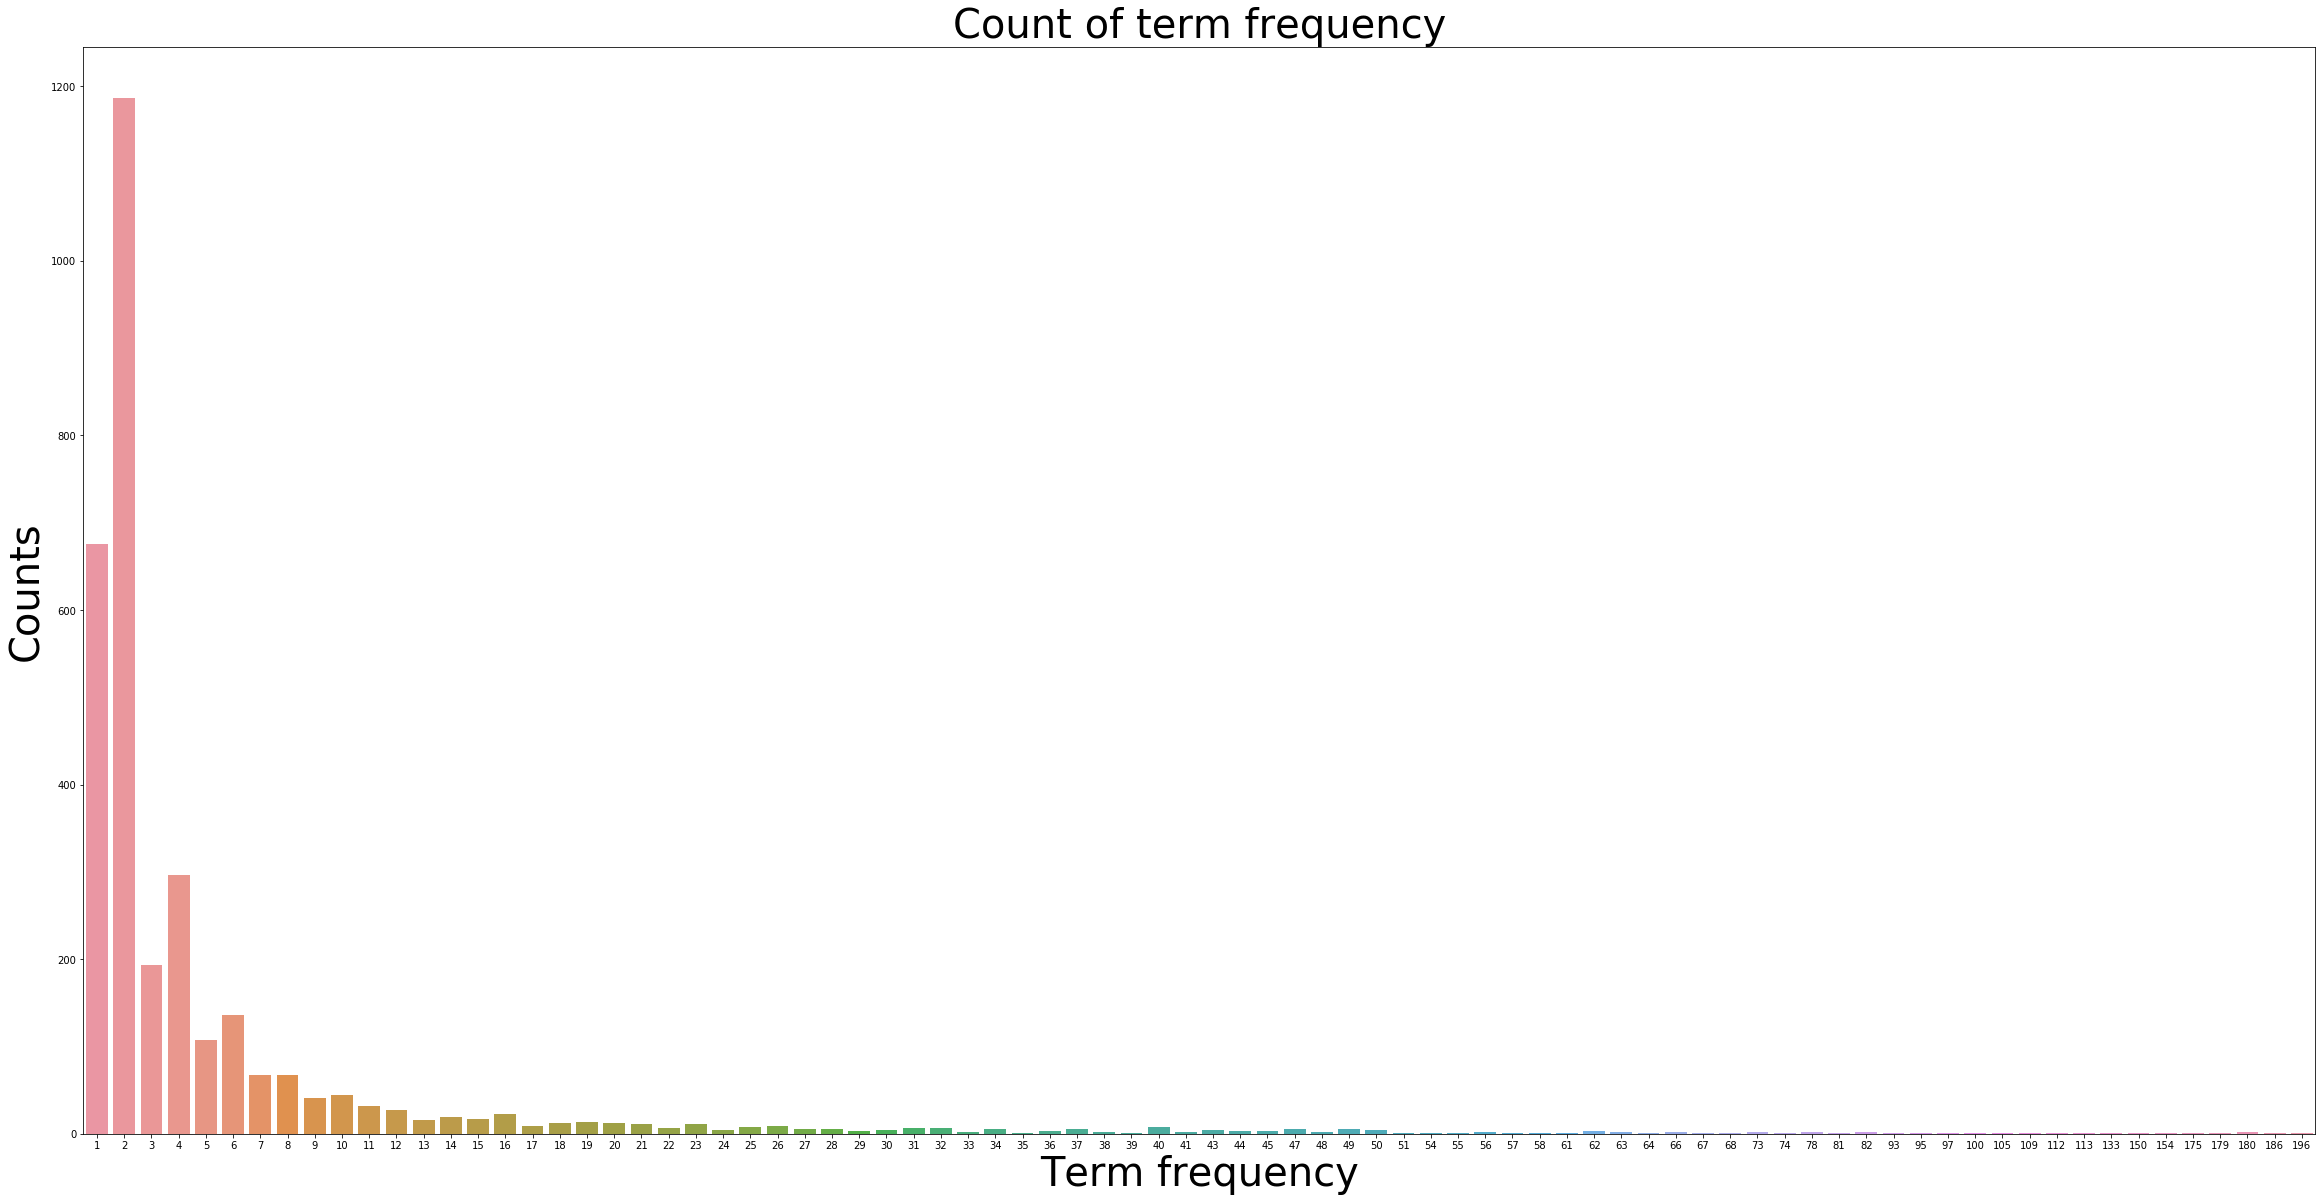

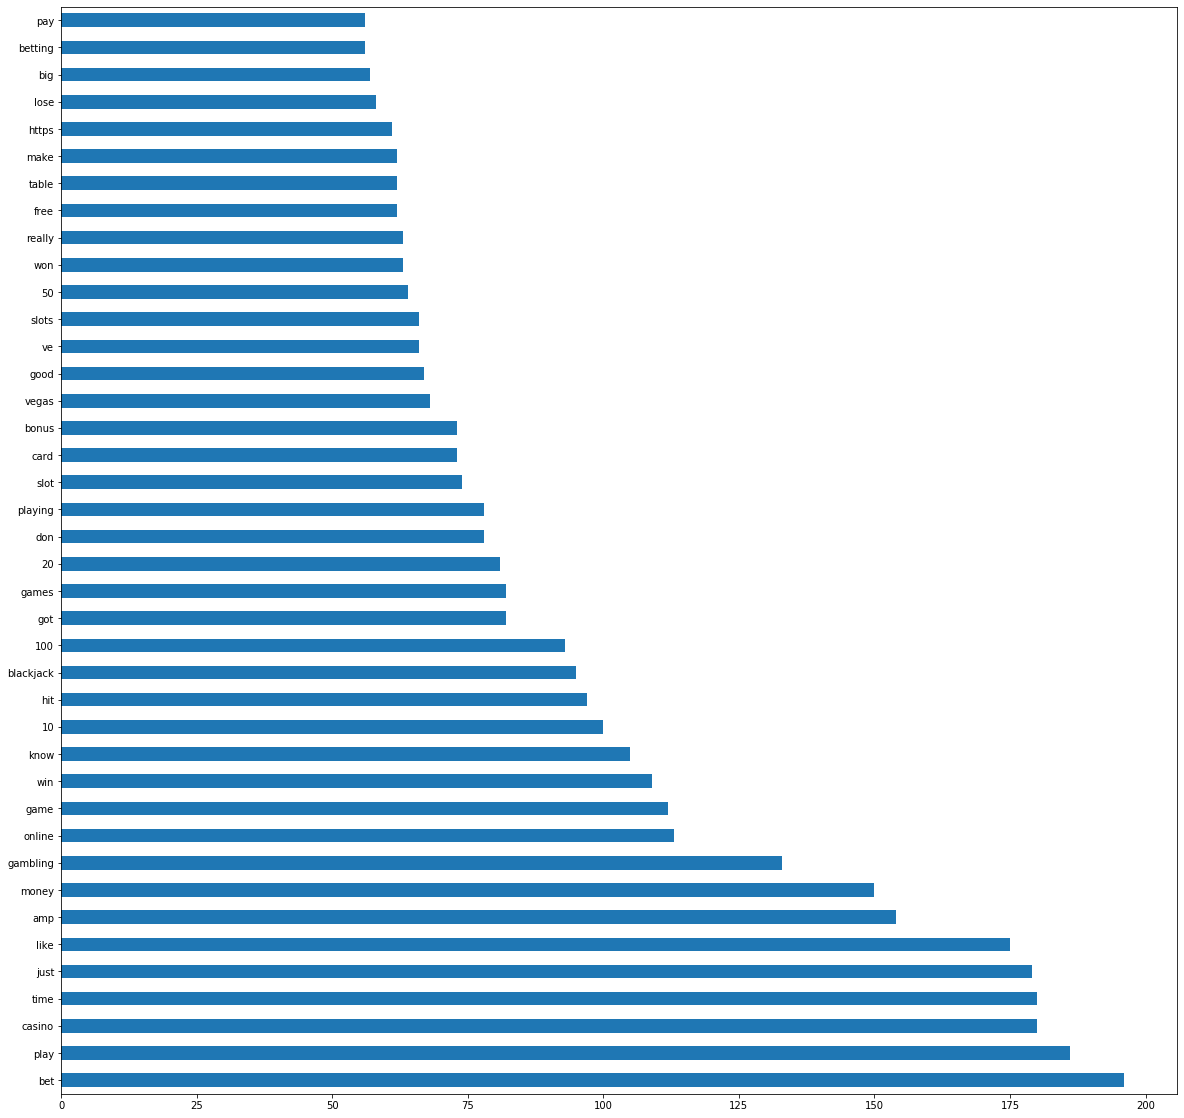

In [20]:
# plot gambling word count
word_count_plot(combined[combined.subreddit==0])

There are a total of ~3200 features and on average each features appears 6 times. The mode of the term frequency is 2 with above 1750 (ie. about half of the features only appears once). These might not be reliable classification features.
Nevertheless, we have a couple of words with high term frequency such as 'bet' (ie. words like 'bet' are highly used in the context of gambling). These few outliers of high term frequency will be useful in identifying the subreddit if the occurance of these words are sparse in the other. However, we also noticed higher frequency of 'https:' terms which are probably webpage links. We need to take note on this.

count    6933.000000
mean        7.439060
std        29.170395
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       947.000000
dtype: float64

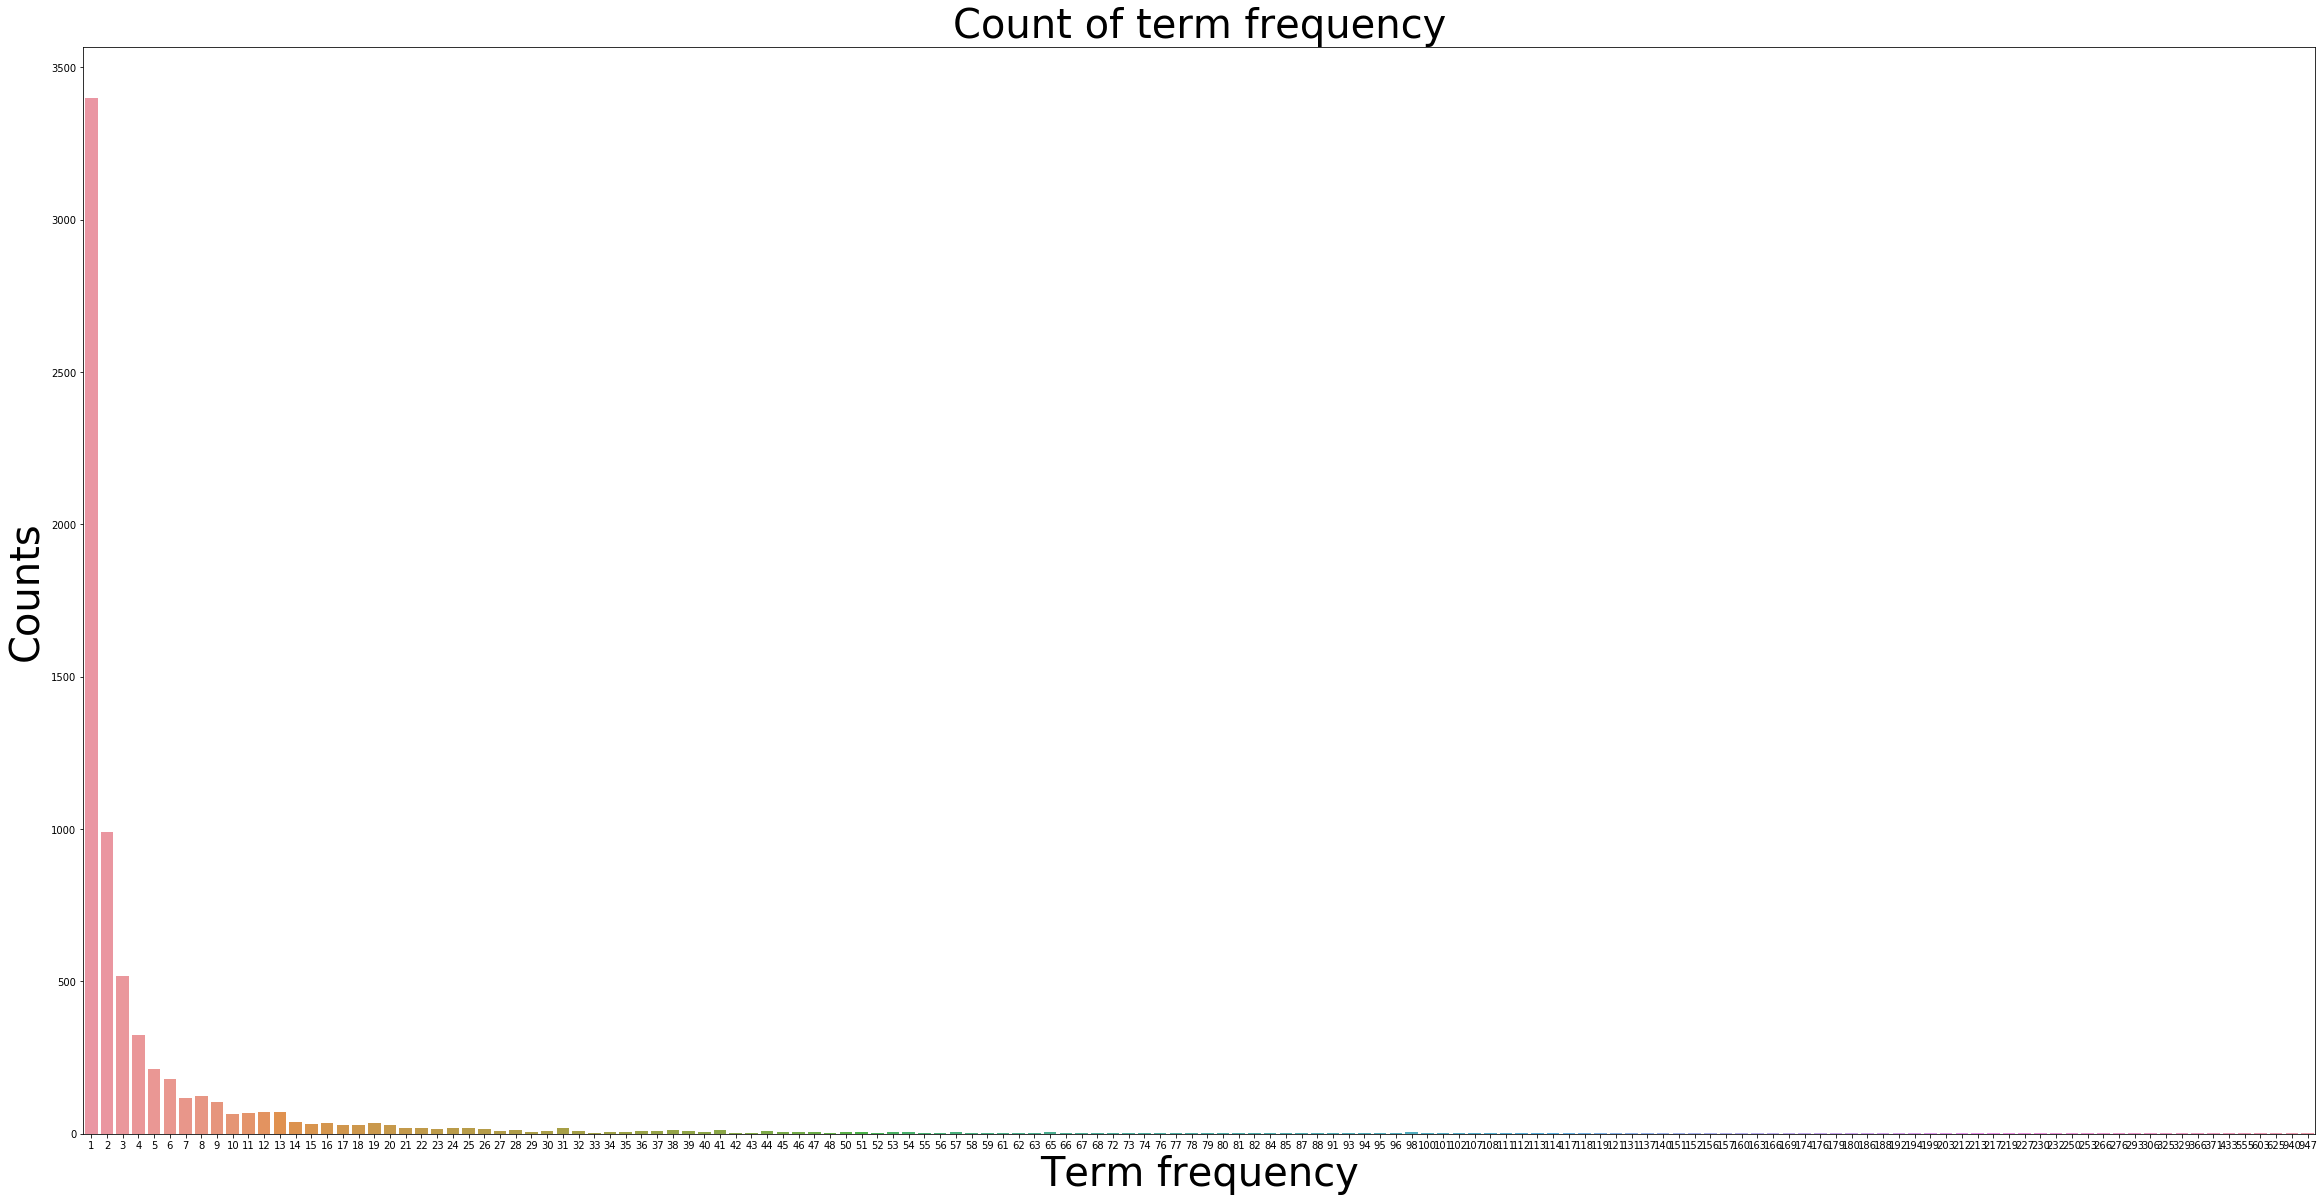

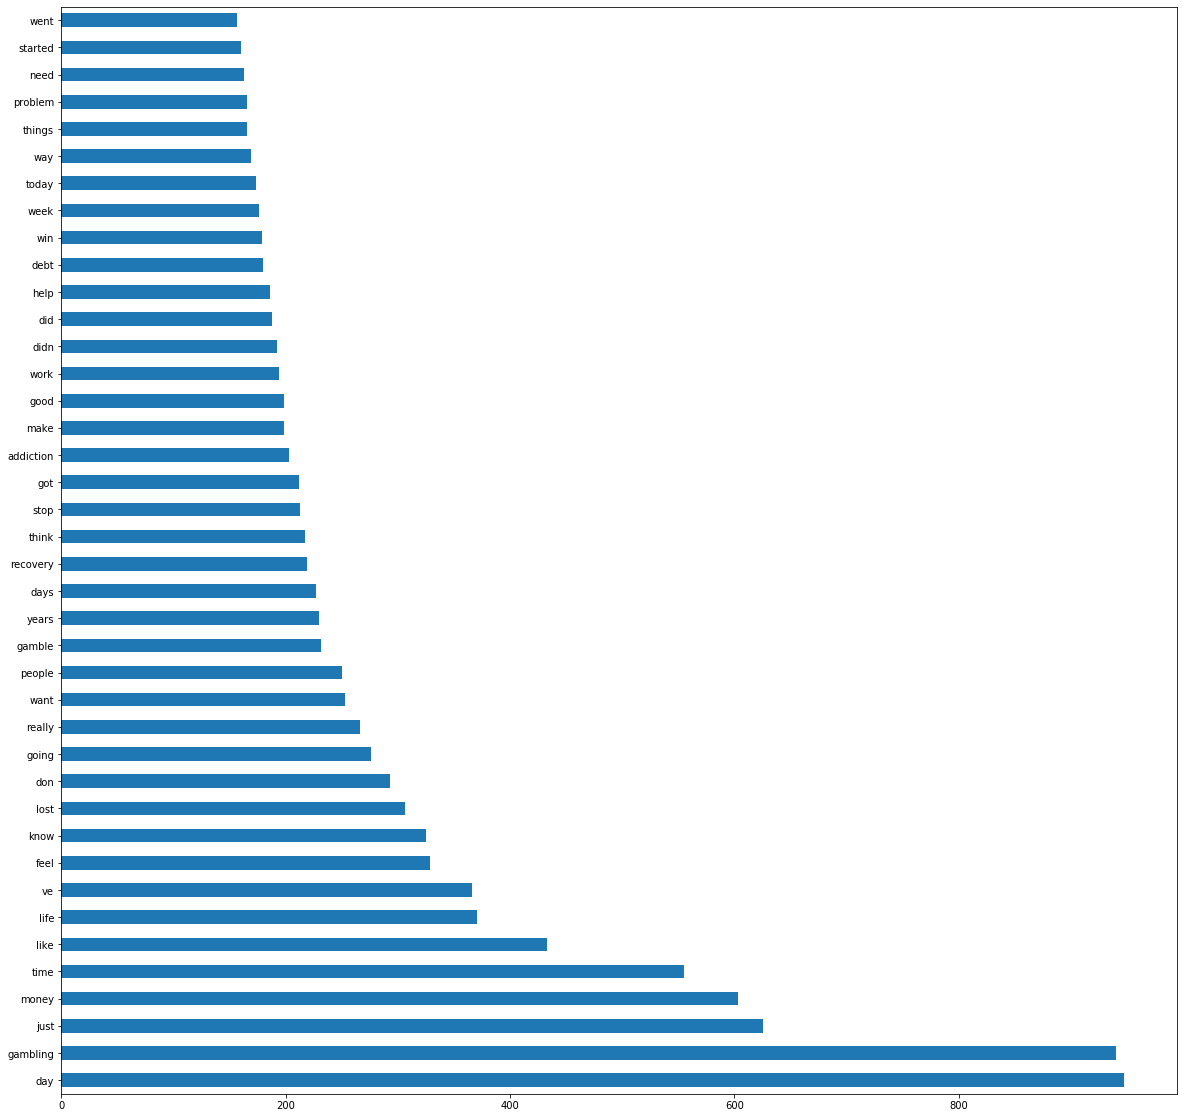

In [21]:
# plot problemgambling word count
word_count_plot(combined[combined.subreddit==1])

We notice similar profile for problemgambling.  
Absurdly high occurance of recurring words within both subreddit if unique can help in identifying the 2 subreddits. 
Thus, it is very likely to build a classification model around the data.

In [22]:
combined.to_csv('datasets/cleaned_data.csv')

## Pre-processing and Modelling

We will want to form our countvectorizer accordingly by the steps
tokenize->remove stop words->lemmatize->train_test_split->train. But there a option in CountVectorizer that helps us tokenize... we can attempt to use the option to lemmatize the token as well.

In [23]:
# creating a class of tokenizer to throw into CountVector
class LemTokenizer():
    # need to init as a Stemmer Object
    def __init__(self):
        self.lem = WordNetLemmatizer()
        self.tokenizer=RegexpTokenizer('\w\w+')
    # returns a list of the lem tokens back for the text (we use call so that it can be used as function)
    def __call__(self, text):
        return [self.lem.lemmatize(t) for t in self.tokenizer.tokenize(text)]

## Model 1: MultinomialNB + CountVectorizer

We can use the multinomial NB since we have muliple discrete features which is the counts of words for this instance which would give us a large matrix of integer corresponding to the word and the document the word is found. We can also use the Countvectorizer that will return us the matrix of integers from the text which is necessary in model building since it is harder to do mathematical methods on strings.

However, using the vectorizer meant that we assume that words that appear are independent of one another (we can use bigram to lower this dependence but we will let the model choose whether to do so via GridSearch).

Since we have more gambling post than problemgambling (imbalance in class) we cannot use accuracy as a good score, but rather specificity or sensitivity.

In [24]:
pipe_nb = Pipeline([
    # inputting the 2 class and stop_words inside
    ('cvec',CountVectorizer(tokenizer=LemTokenizer(),stop_words='english')),
    ('NBmulti',MultinomialNB())
     ])

In [25]:
X=combined['text']
y=combined['subreddit']

In [26]:
X_train, X_test, y_train, y_test=train_test_split(X,y,stratify=y,random_state=4565891)

In [27]:
# getting a baseline
baseline=y_test.value_counts(normalize=True)
baseline

1    0.612987
0    0.387013
Name: subreddit, dtype: float64

In [28]:
# gridsearch to obtain best parameters
pipe_nb_params = {
    # we chose to limit about 300 becasue reddit post length usually arent that long
    'cvec__max_features': [250, 300],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs_nb = GridSearchCV(pipe_nb, param_grid=pipe_nb_params, cv=3)
gs_nb.fit(X_train, y_train)
print(gs_nb.best_score_)
gs_nb.best_params_

C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing

C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing

0.8889852558542931


{'cvec__max_df': 0.9,
 'cvec__max_features': 300,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

In [29]:
# getting accuracy on test set
accuracy_nb=gs_nb.score(X_test,y_test)
y_pred=gs_nb.predict(X_test)

In [30]:
# confusion matrix to get recall etc
cm_nb=confusion_matrix(y_test,y_pred)
tn_nb, fp_nb, fn_nb, tp_nb = cm_nb.ravel()

In [31]:
sensitivity_nb=tp_nb/(tp_nb+fn_nb)
specificity_nb=tn_nb/(tn_nb+fp_nb)

In [32]:
scores_table= pd.DataFrame([gs_nb.best_score_,accuracy_nb,sensitivity_nb,specificity_nb,roc_auc_score(y_test,y_pred)],index=['train_accuracy','test_accuracy','sensitivity','specificity','roc'],columns=['Multinomial'])
scores_table

,Multinomial
train_accuracy,0.888985
test_accuracy,0.872727
sensitivity,0.961864
specificity,0.731544
roc,0.846704


As expected, test_accuracy is lower than train accuracy.
Judging from the accuracy scores, it outperforms the baseline.

Lets perform one more model.

## Model 2: LogisticRegression + TFIDF

Tfidf works a little differently from countvectorizer. Instead of returning a count for the words, it returns a value that accounts for the rarity of the word. The rarer the word, the higher the value. This helps reduce weightage on words like 'casino' that appears frequently so that we can see more surprising words appear.

We also chose logistic regression as the regressor since logistic regresion is known to work well for models that expects 2 output 1 and 0 where 1 shows the post is from problemgambling and 0 is from gambling.

Scoring is the same as MultinomialNB.

In [33]:
pipe_lr= Pipeline([
    # inputting the 2 customized class and stop_words inside
    ('tfidf',TfidfVectorizer(tokenizer=LemTokenizer(),stop_words='english')),
    ('lr',LogisticRegression())])

In [34]:
# gridsearch to obtain best parameters
pipe_lr_params = {
    'tfidf__max_features': [250, 300],
    'tfidf__min_df': [2,3],
    'tfidf__max_df': [.95, .98],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'lr__C': np.linspace(0.1,1,3)
}
gs_lr = GridSearchCV(pipe_lr, param_grid=pipe_lr_params, cv=3)
gs_lr.fit(X_train, y_train)
print(gs_lr.best_score_)
gs_lr.best_params_

C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

0.9193408499566349


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'lr__C': 1.0,
 'tfidf__max_df': 0.95,
 'tfidf__max_features': 300,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 1)}

In [35]:
# repeating for lr
accuracy_lr=gs_lr.score(X_test,y_test)
y_pred_lr=gs_lr.predict(X_test)
cm_lr=confusion_matrix(y_test,y_pred_lr)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
sensitivity_lr=tp_lr/(tp_lr+fn_lr)
specificity_lr=tn_lr/(tn_lr+fp_lr)

In [36]:
logistic=pd.DataFrame([gs_lr.best_score_,accuracy_lr,sensitivity_lr,specificity_lr,roc_auc_score(y_test,y_pred_lr)],
                                     index=['train_accuracy','test_accuracy','sensitivity','specificity','roc'],
                                     columns=['Logistic'])
scores_table=scores_table.join(logistic)

In [37]:
baseline_=pd.Series([baseline[1],baseline[1],'NaN','NaN','NaN'],index=['train_accuracy','test_accuracy','sensitivity','specificity','roc'],name='baseline')
scores_table=scores_table.join(baseline_)

## Evaluations

The baseline would be measured using the value_counts of the 2 class since it the chance of getting the assignment right randomly if given only the subreddit column. Models need to outperform that.

Below is the scoring of the models

In [38]:
scores_table

,Multinomial,Logistic,baseline
train_accuracy,0.888985,0.919341,0.612987
test_accuracy,0.872727,0.916883,0.612987
sensitivity,0.961864,0.923729,NaN
specificity,0.731544,0.906040,NaN
roc,0.846704,0.914885,NaN


Both model do not have much variance issue since the scores between train and test accuracy doesnt vary too much. The model generalise quite well

As mentioned in the problem statement, we would favour sensitivity as the key metric since we do not want to leave minimal problem gambler identified. However, the tradeoff for roc and specificity is too high for the small difference in sensitivity. Thus we chose Logistics with TFIDF. Also TFIDF could have show more surprising features which will be what our secondary audience, NCPG, might be more interested in where we can provide less obvious features seen in problem gambling to gambling.

Now we want to see if we can get the word feature out...after we fit the entire dataset in

In [39]:
gs_lr.fit(X,y)
gs_lr.best_params_

C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\li

{'lr__C': 1.0,
 'tfidf__max_df': 0.95,
 'tfidf__max_features': 300,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 1)}

In [40]:
pipe_lr= Pipeline([
    # inputting the optimized features
    ('tfidf',TfidfVectorizer(tokenizer=LemTokenizer(),stop_words='english',max_df=0.95,max_features=300,min_df=3,ngram_range=(1,1))),
    ('lr',LogisticRegression())])

In [41]:
pipe_lr.fit(X,y)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.95, max_features=300,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...',
                                 tokenizer=<__main__.LemTokenizer object at 0x000001859B86E588>,
                                 use_idf=True, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [42]:
# getting features names from tfidf
features=pipe_lr['tfidf'].get_feature_names()
# getting coefs from lr (note that the coefs will match the feature name since logistic regression does not drop coefs)
coefs=[i for j in pipe_lr['lr'].coef_ for i in j]
coef=pd.DataFrame([coefs,np.abs(coefs)], columns=features,index=['coef','coef_abs']).transpose()

### Features

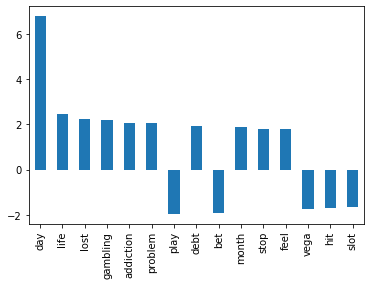

In [43]:
#looking at top 15 word features
coef.sort_values('coef_abs',ascending=False).coef[:15].plot(kind='bar')

We can see the presence of certain words that can help us predict and classify the 2 subreddit accurately. And it makes sense.. words related to gambling like 'casino','bet' has negative coefficients while those related to problemgambling such as 'life','day' were positive since the sum of the coefficients would determine whether the post is problemgambling (if closer to 1) and gambling (if closer to negative).

For the strongest indicator, we notice that the context of the day is used mostly in problem gambling by a few posters indicating how many days they were off gambling or till they broke their streak. This meant that some features while useful to differentiate the post might not be as useful as tell tale sign for problem gambling. However, this gives me a new idea of a different topic... if we trace these posters, could we tell whether tracking the days for abstinence for an individual is an effective tool for quitting gambling? We can then see whether these poster regress or not. In fact, posts with days are so commonly seen that this reddit is more oftenly updated than gambling (if you ignore repost).

![title](images/Capture.png)

### ROC

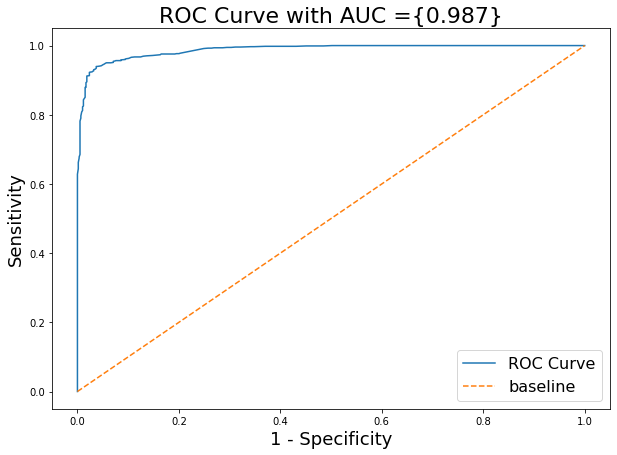

In [44]:
#codes supplied from ROC lecture
# creating dataframe true value and predicted probabilities
pred_proba = [i[1] for i in pipe_lr.predict_proba(X)]

pred_df = pd.DataFrame({'true_values': y,
                        'pred_probs':pred_proba})
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC =' + str({round((roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])),3)}), fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

To access the validity of our model, we also plotted the ROC curve to show visually how well the model works. It has a very high roc curve because we are predicting on the same set of values that we train them on.

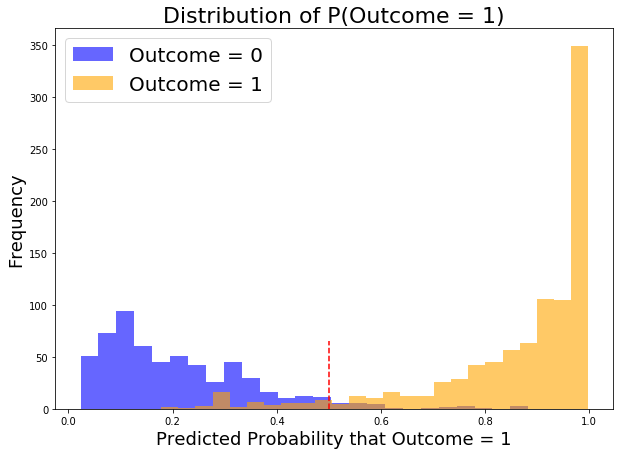

In [45]:
# plotting the spread between the subreddit threads to see the overlap
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

## Conclusions and Recommendations

To summarize, we have looked at the text features in EDA and their distributions while deciding if the data at hand will be suitable for a model and decided to test on 2 models separately. We then accessed that Logistic with TFIDF would be the more appropriate model given that we are trying to maximize sensitivity. We then craft our final model using all the available dataset.

In conclusion, we have managed to produce a Logistic Regression model that was able to differentiate the posts from the 2 subreddit, problemgambling and gambling that is significantly higher than a random baseline with a test roc score of 0.91. With this, we can help individuals identify whether they are getting addicted to gambling. We might also be able to have provide further validation or insights for gambling research conducted by NCPG via the NLP.

However, there are several limitations on this research. The first would be the context. Since reddit is a US-centric site the terminology might be less used in Singapore such as 'Vegas'. 

Secondly, the posts might not be the best representation for the question in the first place. What we would like is a clearer division of problem gamblers and leisure gamblers and the post they write but that might not be true. Problem gamblers might whom are not aware might be making post in the gambling subreddit. A better question might be: iven the problem subreddit data, could we identify who are the problem gamblers are in the gambler subreddit.

Moving forward, we could be receiving account data from NCPG with is more contextual to Singapore scenario. We can also futher research on using reddit to assess how useful is keeping track of no-gambling days in changing a problem gambler's habit which is something our secondary audience will be very interested in.